This notebook is for testing methods for performing a tidal analysis on the RIOPS currents.

Data
* RIOPS forecasts June 1-30, 2022, hourly frequency, surface currents (30 days)
* First 6 hours of every forecast is used (best esitmate)

Unfortuantely, we don't have hourly data for a continuous time series at the surface. I'm worried that compiling the best esitmate from the forecasts will results in an inaccruate tidal analysis

# Notes on tidal analysis
Using the six big resovable constituents, followng the 30-day analysis presented here: https://www.nature.com/articles/s41597-020-00578-z
* M2, N2, S2, K1, O1, Q1 

This might need to go into a script!

In [1]:
import pytides.constituent as constituent
my_consts = [
constituent._M2, constituent._S2, constituent._N2, constituent._K1, constituent._O1, constituent._Q1,
]

In [2]:
import glob
import os
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pytides.tide import Tide

In [3]:
plt.style.use('seaborn-talk')

In [4]:
data='/home/soontiensn/data/DenisLefaivre/riops/data/'

In [5]:
ufiles=glob.glob(os.path.join(data, '*VOZOCRTX*.nc'))
ufiles.sort()
du=xr.open_mfdataset(ufiles)

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [6]:
du

<xarray.Dataset>
Dimensions:              (time: 720, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 30.56034 30.58307 ... 41.46735
    longitude            (yc, xc) float32 221.2824 221.31534 ... 20.87038
  * time                 (time) datetime64[ns] 2022-06-01 ... 2022-06-30T23:00:00
Data variables:
    polar_stereographic  (time) |S1 b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    vozocrtx             (time, yc, xc) float32 dask.array<shape=(720, 1610, 1770), chunksize=(1, 1610, 1770)>
Attributes:
    Conventions:      CF-1.6
    title:            Instantaneous sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Ocean Prediction System: version 2.2.0
    product_version:  RIOPS_2.2.0_F
    creation_

In [7]:

lons = du.longitude
lats = du.latitude

/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/soontiensn/miniconda/envs/tidal/lib/python3.7/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'RIOPS mean u velocity June  1-30, 2022')

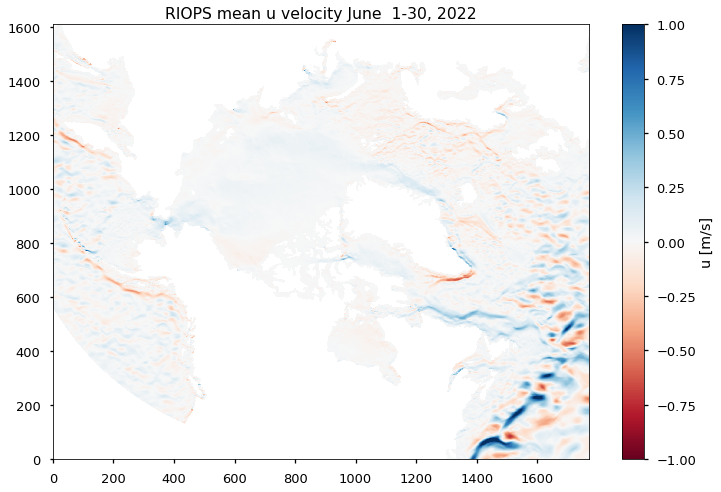

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
umean = du.vozocrtx.mean(dim='time').values
mesh=ax.pcolormesh(umean,vmin=-1,vmax=1,cmap='RdBu')
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('u [m/s]')
ax.set_title('RIOPS mean u velocity June  1-30, 2022')


# Plan
* Tidal analysis on U
* Every grid point
* Organize outputs into arrays

In [9]:
def tidal_analysis(speeds, times,  print_const=True, constituents=my_consts):
    demeaned = speeds - speeds.mean()
    dates=pd.to_datetime(times)
    if constituents:
        tide = Tide.decompose(demeaned,dates, constituents=my_consts)
    else:
        tide = Tide.decompose(demeaned,dates,)
    
    #print constituents
    constituent = [c.name for c in tide.model['constituent']]
    df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
    
    return df

In [21]:
def analyze_position(i,j, variable):
    speeds = variable.isel(xc=i,yc=j).values
    if np.isnan(speeds).any():
        df=None
    else:
        times = variable.time.values
        df = tidal_analysis(speeds, times, constituents=my_consts)
    return df

In [29]:
u = du.vozocrtx
mask = np.ma.masked_invalid(u.isel(time=0).values).mask
shape = du.vozocrtx.isel(time=0).shape
i,j=0,0
df = analyze_position(i,j, u)
print(df)
if df is None:
    print(np.nan)

None
nan


In [30]:

K1_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
K1_pha = np.ma.masked_array(np.zeros(shape),mask=mask)
O1_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
O1_pha = np.ma.masked_array(np.zeros(shape),mask=mask)
Q1_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
Q1_pha = np.ma.masked_array(np.zeros(shape),mask=mask)
M2_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
M2_pha = np.ma.masked_array(np.zeros(shape),mask=mask)
S2_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
S2_pha = np.ma.masked_array(np.zeros(shape),mask=mask)
N2_amp = np.ma.masked_array(np.zeros(shape),mask=mask)
N2_pha = np.ma.masked_array(np.zeros(shape),mask=mask)

In [36]:
for j in range(shape[0]):
    for i in range(shape[-1]):
        m = mask[j,i]
        if m:
            continue
        else:
            df = analyze_position(i,j,u)
            K1_amp[j,i] = df['amplitude']['K1']
            K1_pha[j,i] = df['phase']['K1']
            O1_amp[j,i] = df['amplitude']['O1']
            O1_pha[j,i] = df['phase']['O1']
            Q1_amp[j,i] = df['amplitude']['Q1']
            Q1_pha[j,i] = df['phase']['Q1']
            M2_amp[j,i] = df['amplitude']['M2']
            M2_pha[j,i] = df['phase']['M2']
            S2_amp[j,i] = df['amplitude']['S2']
            S2_pha[j,i] = df['phase']['S2']
            N2_amp[j,i] = df['amplitude']['N2']
            N2_pha[j,i] = df['phase']['N2']

KeyboardInterrupt: 

In [ ]:
K1_amp

In [37]:
i

1374

In [38]:
j

1

In [35]:
K1_amp

masked_array(
  data=[[--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)